# Data Preprocessing

- Missing value imputation
- Rare category
- Feature Transformation and Scaling

## Split Train and Validate Set
 Split ratio $=$ train ($80$) $:$ validate ($20$)

In [ ]:
X = train_data.copy()

In [ ]:
train_index, validate_index = train_test_split(X.is_promoted, test_size=0.2, stratify=X.is_promoted, random_state=1)
train_index, validate_index = train_index.index, validate_index.index

In [ ]:
del train_data

## Missing value Imputation

### `education`

In [ ]:
education_imputer = SimpleImputer(strategy='constant', fill_value='missing')

In [ ]:
# fit using train data only
education_imputer.fit(np.array(X.education[train_index]).reshape(-1,1))

SimpleImputer(add_indicator=False, copy=True, fill_value='missing',
              missing_values=nan, strategy='constant', verbose=0)

In [ ]:
# Transform whole dataset
X.education = education_imputer.transform(np.array(X.education).reshape(-1,1))

### `previous_year_rating` [TODO : Need for functional imputer]

In [ ]:
def rating_na_indicator(column):
    '''
        :column : An iterable. if scalar will be converted to iterable.
        It returns an indicator variable; 1 if nan else 0
    '''

    column = pd.Series(column)

    indicator_column = column.apply(lambda x : 1 if np.isnan(x) else 0 )

    return indicator_column

In [ ]:
def rating_corrected(data):
    '''
        If length of service = 1, then previous years rating cannot exist
        This function substitues values as such with np.nan. 
        Expectation is to treat the value same as missing vale would be treated.

        Parameter
        --------------------------------
        :data : Dataframe of training data with atleast `previous_year_rating`
                and `length_of_service`

        Returns
        ---------------
        A column with values substituted to np.nan if length of service =1 
        and pevious_year_rating != nan, else same value as already present.
    '''
    
    rating = np.where((data.length_of_service == 1) & (data.previous_year_rating.notna()), np.nan, data.previous_year_rating)

    return rating

In [ ]:
def preprocess_rating(data):

    data['previous_year_rating'] = rating_corrected(data)
    rating_na = rating_na_indicator(data['previous_year_rating'])
    
    return data['previous_year_rating'], rating_na

In [ ]:
rating_imputer = SimpleImputer(strategy='most_frequent')

In [ ]:
X.previous_year_rating, X['previous_rating_na'] = preprocess_rating(X)

In [ ]:
# fit only on training data
rating_imputer.fit(np.array(X.previous_year_rating[train_index]).reshape(-1,1))

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

In [ ]:
# transform all data
X.previous_year_rating = rating_imputer.transform(np.array(X.previous_year_rating).reshape(-1,1))

## Handle high cardinality of `region`

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CardinalityImputer(BaseEstimator, TransformerMixin):

    def __init__(self, threshold, replace_term='rare_region'):

        self.threshold = threshold
        self.replace_term = replace_term

        self.rare_category = []

    def only_one_col(self, column):

        column = np.array(column)
        return len(column.shape) == 1


    def find_rare_category(self, feature, threshold):
    
        '''
            Finds categories that are smaller than threshold percentage.
            This function is similar to fit() of any transformer.

            Parameter
            --------------------
            :feature : should be one column.
                    expected to be of training data 
            :threshold : frequency threshold in percentage


        '''
        #feature = pd.Series(feature)

        rare_category = np.array(feature.value_counts(dropna=False)[
                        (feature.value_counts(dropna=False)/feature.shape[0])*100 < threshold
                    ].index)
        
        return rare_category


    def fit(self, feature):

        if not self.only_one_col(feature):
            raise ValueError('''Only One Feature Can be processed.
                             More than one Column provided.''')
        
        feature = pd.Series(feature)

        #self.rare_category = find_rare_category(feature[train_index], 1)
        self.rare_category = self.find_rare_category(feature, 1)

        return self

    
    def transform(self, feature):

        if not self.only_one_col(feature):
            raise ValueError('''Only One Feature Can be processed.
                             More than one Column provided.''')
            
        feature = pd.Series(feature)

        feature = feature.apply(lambda x: self.replace_term if x in self.rare_category else x)

        return feature

In [ ]:
region_cardinality_imputer = CardinalityImputer(1, replace_term='rare_region')

In [ ]:
region_cardinality_imputer.fit(X.region[train_index])

CardinalityImputer(replace_term='rare_region', threshold=1)

In [ ]:
X.region = region_cardinality_imputer.transform(X.region)

## Scale and Transform Numerical data

- Use PowerTrasformer with 'yeo-johnson' method. First transforms the data; attempting towards Gaussian and then standardizes.

In [ ]:
numerical_features = ['no_of_trainings', 'age', 'length_of_service', 'avg_training_score']

### Power Transform : `Yeo-Johnson`

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
yeo_johnson_data = X.loc[:, numerical_features]

In [ ]:
for num_var in yeo_johnson_data.columns:
    # fit with training data
    transformer = PowerTransformer(standardize=True).fit(np.array(yeo_johnson_data[num_var][train_index]).reshape(-1,1))
    # transform your data
    yeo_johnson_data[num_var] = transformer.transform(np.array(yeo_johnson_data[num_var]).reshape(-1,1))

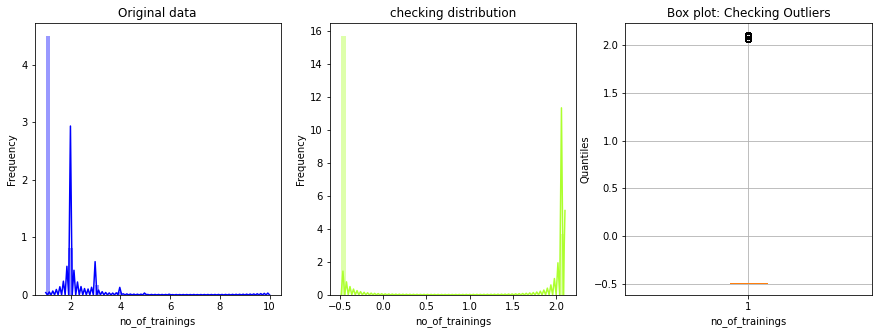

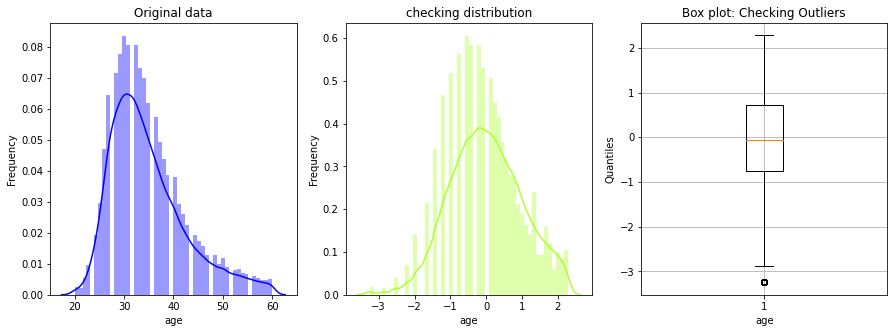

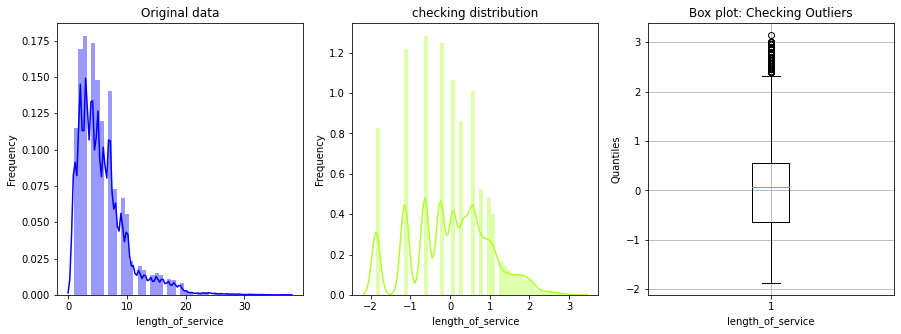

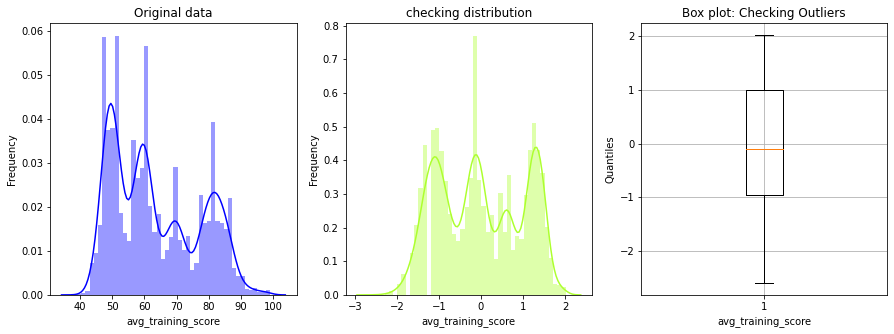

In [ ]:
for feature in yeo_johnson_data.columns:

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    plt.subplot(ax[0])
    sns.distplot(X.loc[:, feature], color='blue')
    plt.title('Original data')
    plt.ylabel('Frequency')
    plt.xlabel(feature)
    
    plt.subplot(ax[1])
    sns.distplot(yeo_johnson_data.loc[:, feature], color='greenyellow')
    plt.title('checking distribution')
    plt.ylabel('Frequency')
    plt.xlabel(feature)

    plt.subplot(ax[2])
    plt.boxplot(yeo_johnson_data.loc[:, feature])
    #plt.xticks([1,2],('Promoted','Not Promoted'))
    plt.xlabel(feature)
    plt.ylabel('Quantiles')
    plt.title('Box plot: Checking Outliers')
    plt.grid()


    plt.show()

In [ ]:
del yeo_johnson_data

### Power Transform: `Box-Cox`

$\because$ there is no negative value and neither there is any logical chance of having any negative value we can use Box - cox transform.

### Feature Standardisation

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
standardised_data = X.loc[:, numerical_features]

In [ ]:
for num_var in standardised_data.columns:
    # fit with training data
    scaler = StandardScaler().fit(np.array(standardised_data[num_var][train_index]).reshape(-1,1))
    #PowerTransformer(method='box-cox', standardize=True).fit(np.array(box_cox_data[num_var][train_index]).reshape(-1,1))
    # transform your data
    standardised_data[num_var] = scaler.transform(np.array(standardised_data[num_var]).reshape(-1,1))

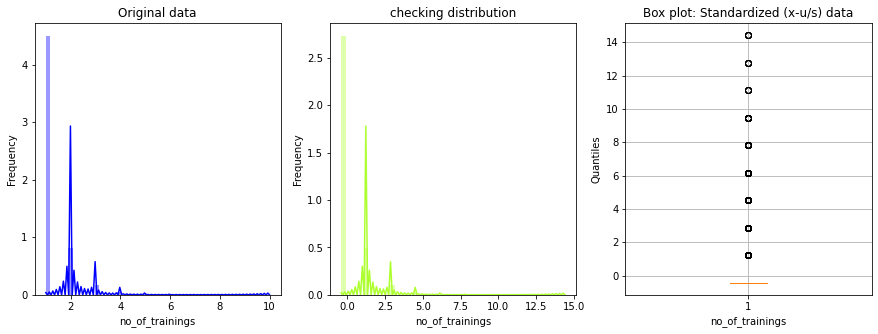

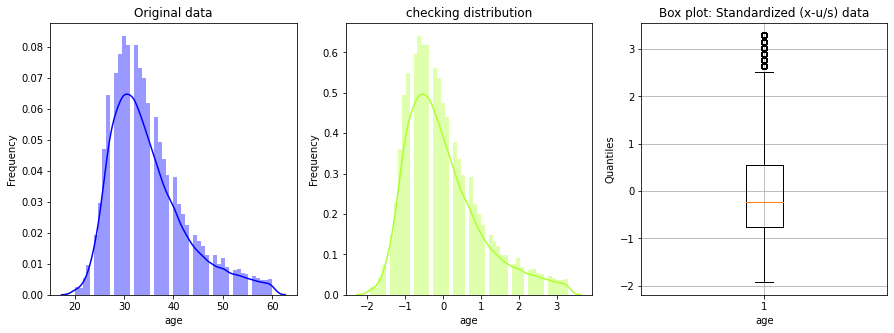

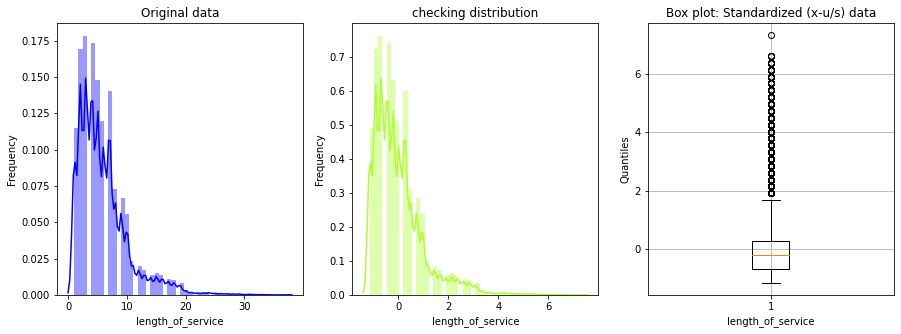

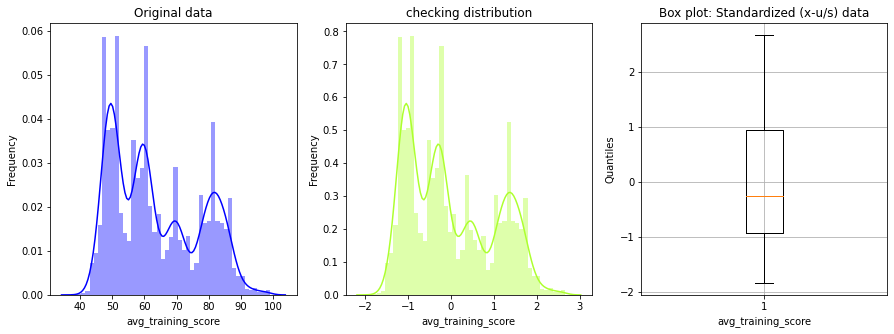

In [ ]:
for feature in standardised_data.columns:

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    plt.subplot(ax[0])
    sns.distplot(X.loc[:, feature], color='blue')
    plt.title('Original data')
    plt.ylabel('Frequency')
    plt.xlabel(feature)
    
    plt.subplot(ax[1])
    sns.distplot(standardised_data.loc[:, feature], color='greenyellow')
    plt.title('checking distribution')
    plt.ylabel('Frequency')
    plt.xlabel(feature)

    plt.subplot(ax[2])
    plt.boxplot(standardised_data.loc[:, feature])
    plt.xlabel(feature)
    plt.ylabel('Quantiles')
    plt.title('Box plot: Standardized (x-u/s) data')
    plt.grid()


    plt.show()

In [ ]:
del standardised_data

In [ ]:
box_cox_data = X.loc[:, numerical_features]

In [ ]:
for num_var in box_cox_data.columns:
    # fit with training data
    transformer = PowerTransformer(method='box-cox', standardize=True).fit(np.array(box_cox_data[num_var][train_index]).reshape(-1,1))
    # transform your data
    box_cox_data[num_var] = transformer.transform(np.array(box_cox_data[num_var]).reshape(-1,1))

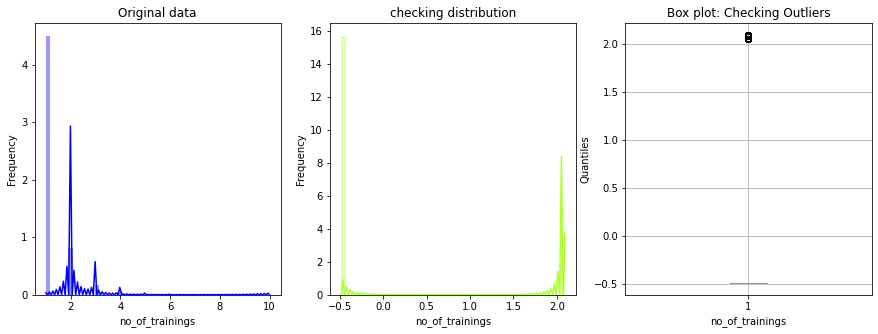

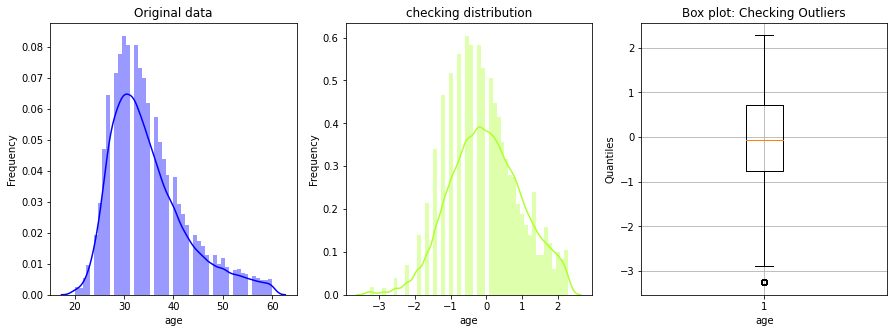

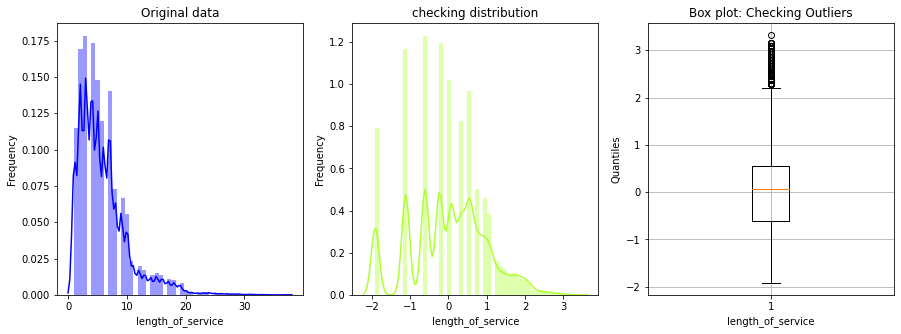

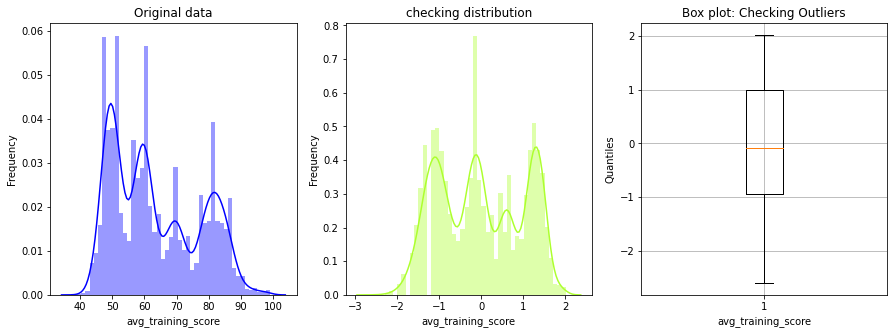

In [ ]:
for feature in box_cox_data.columns:

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    plt.subplot(ax[0])
    sns.distplot(X.loc[:, feature], color='blue')
    plt.title('Original data')
    plt.ylabel('Frequency')
    plt.xlabel(feature)
    
    plt.subplot(ax[1])
    sns.distplot(box_cox_data.loc[:, feature], color='greenyellow')
    plt.title('checking distribution')
    plt.ylabel('Frequency')
    plt.xlabel(feature)

    plt.subplot(ax[2])
    plt.boxplot(box_cox_data.loc[:, feature])
    #plt.xticks([1,2],('Promoted','Not Promoted'))
    plt.xlabel(feature)
    plt.ylabel('Quantiles')
    plt.title('Box plot: Checking Outliers')
    plt.grid()


    plt.show()

In [ ]:
del box_cox_data

### Log Transformation

In [ ]:
from sklearn.preprocessing import FunctionTransformer

In [ ]:
log_data = X.loc[:, numerical_features]

In [ ]:
for num_var in log_data.columns:
    # fit with training data
    transformer = FunctionTransformer(func=np.log1p).fit(np.array(log_data[num_var][train_index]).reshape(-1,1))
    # transform your data
    log_data[num_var] = transformer.transform(np.array(log_data[num_var]).reshape(-1,1))

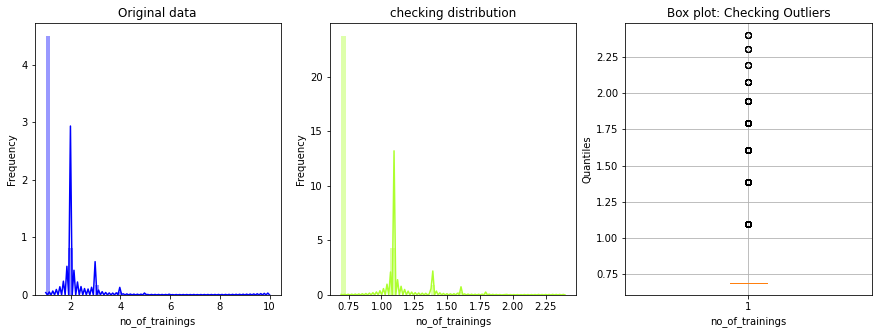

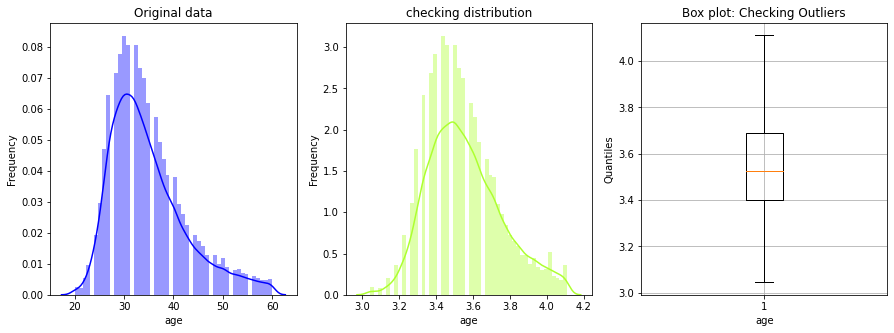

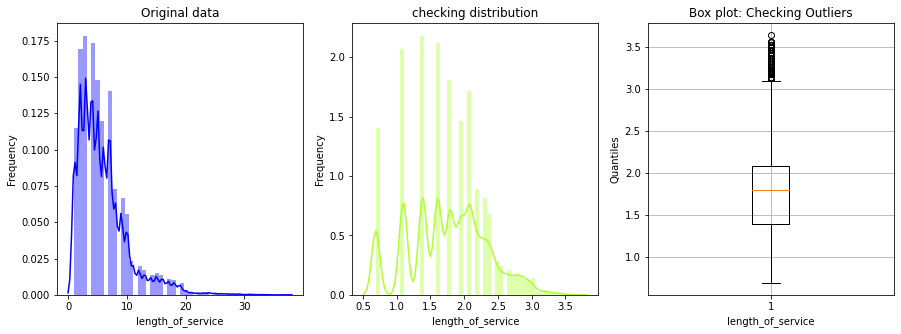

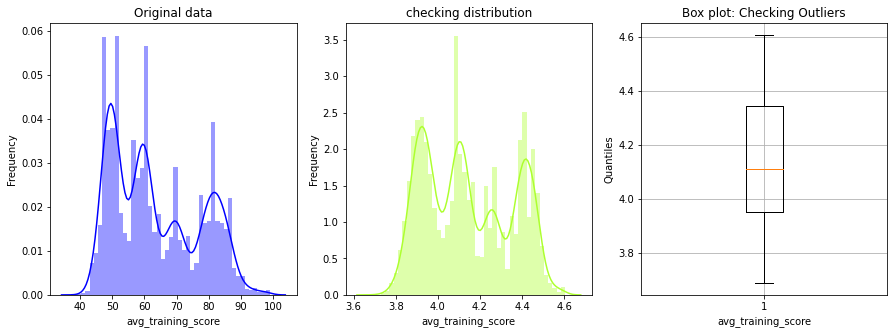

In [ ]:
for feature in log_data.columns:

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    plt.subplot(ax[0])
    sns.distplot(X.loc[:, feature], color='blue')
    plt.title('Original data')
    plt.ylabel('Frequency')
    plt.xlabel(feature)
    
    plt.subplot(ax[1])
    sns.distplot(log_data.loc[:, feature], color='greenyellow')
    plt.title('checking distribution')
    plt.ylabel('Frequency')
    plt.xlabel(feature)

    plt.subplot(ax[2])
    plt.boxplot(log_data.loc[:, feature])
    #plt.xticks([1,2],('Promoted','Not Promoted'))
    plt.xlabel(feature)
    plt.ylabel('Quantiles')
    plt.title('Box plot: Checking Outliers')
    plt.grid()

    plt.show()

In [ ]:
del log_data

### Standardized Log Transformation 

In [ ]:
standardized_log_data = X.loc[:, numerical_features]

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
log_standardized_transformer = Pipeline([('log_transformer', FunctionTransformer(func=np.log1p)),
                                         ('standard_scaler', StandardScaler())
                            ])

In [ ]:
for num_var in standardized_log_data.columns:
    # fit with training data
    transformer = log_standardized_transformer.fit(np.array(standardized_log_data[num_var][train_index]).reshape(-1,1))
    # transform your data
    standardized_log_data[num_var] = transformer.transform(np.array(standardized_log_data[num_var]).reshape(-1,1))

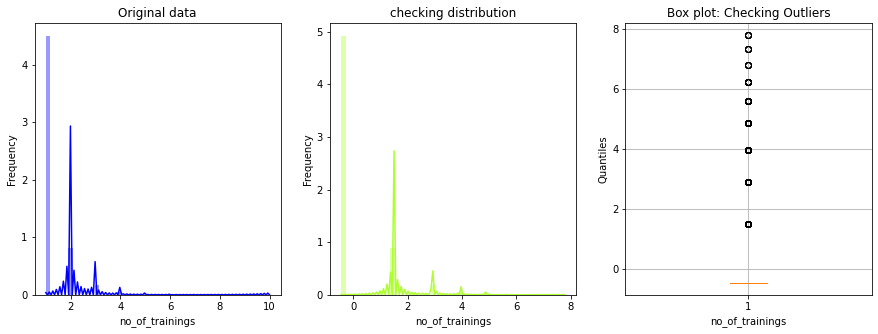

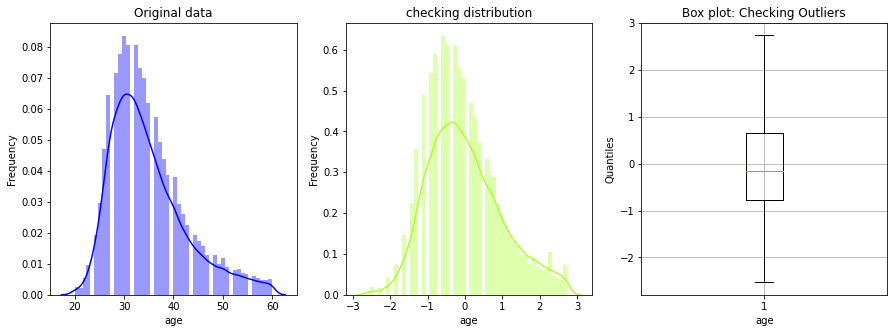

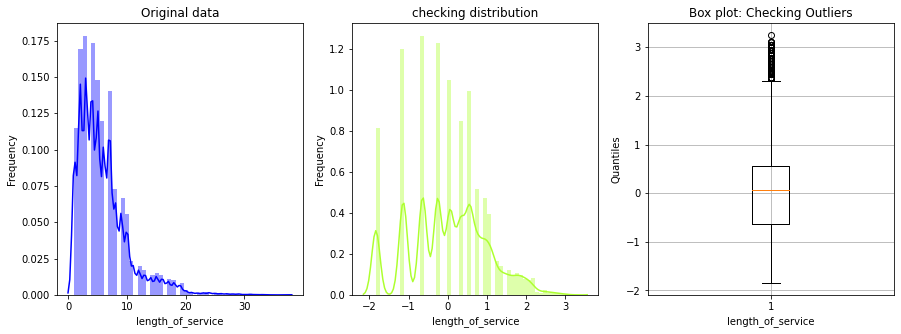

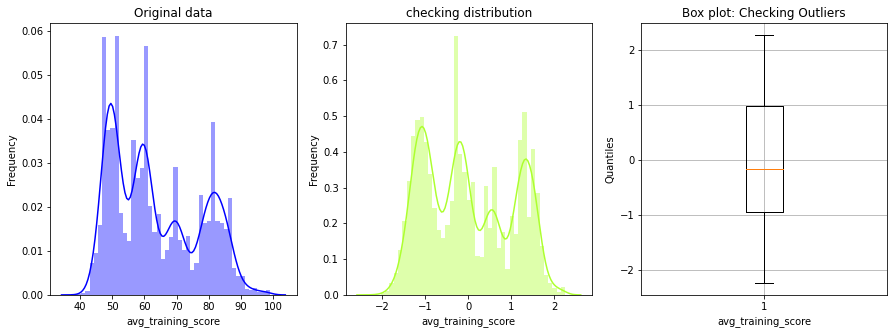

In [ ]:
for feature in standardized_log_data.columns:

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    plt.subplot(ax[0])
    sns.distplot(X.loc[:, feature], color='blue')
    plt.title('Original data')
    plt.ylabel('Frequency')
    plt.xlabel(feature)
    
    plt.subplot(ax[1])
    sns.distplot(standardized_log_data.loc[:, feature], color='greenyellow')
    plt.title('checking distribution')
    plt.ylabel('Frequency')
    plt.xlabel(feature)

    plt.subplot(ax[2])
    plt.boxplot(standardized_log_data.loc[:, feature])
    #plt.xticks([1,2],('Promoted','Not Promoted'))
    plt.xlabel(feature)
    plt.ylabel('Quantiles')
    plt.title('Box plot: Checking Outliers')
    plt.grid()

    plt.show()

In [ ]:
del standardized_log_data

### Selected Transformation: Yeo-Johnson

In [ ]:
for num_var in numerical_features:
    # fit with training data
    transformer = PowerTransformer(standardize=True).fit(np.array(X[num_var][train_index]).reshape(-1,1))
    # transform your data
    X[num_var] = transformer.transform(np.array(X[num_var]).reshape(-1,1))

In [ ]:
X = X.drop(['employee_id'], axis='columns')

## Base Model with all Features

In [ ]:
# load from disk

# X = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Colab Notebooks/data/HR_processed.csv')

# train_index = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Colab Notebooks/data/HR_train_index.csv')
# validate_index = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Colab Notebooks/data/HR_validate_index.csv')

In [ ]:
categorical_features = ['department', 'region', 'education', 'gender',
                        'recruitment_channel','previous_year_rating',
                        'KPIs_met >80%', 'awards_won?', 'previous_rating_na']

In [ ]:
numerical_features = ['no_of_trainings', 'age', 'length_of_service', 'avg_training_score']

In [ ]:
y = X.is_promoted

In [ ]:
data = X.drop(columns='is_promoted')

In [ ]:
# Responsecoding
for feature in categorical_features:
    
    if feature != 'previous_year_rating': # 'previous_year_rating' is already in float
        encoder = ResponseCoding().fit(data.loc[train_index.values.flatten(),feature],
                                       y[train_index.values.flatten()] 
                                      )
        
        data[feature] = encoder.transform(data[feature])[1] # [1] only value for label 1

# Labelencode 
# for feature in data.columns:
    
#     if feature != 'previous_year_rating': # 'previous_year_rating' is already in float
#         encoder = LabelEncoder().fit(data.loc[:,feature])
#         data[feature] = encoder.transform(data[feature])


In [ ]:
tree_clf = DecisionTreeClassifier()

In [ ]:
tree_clf.fit(data.loc[train_index.values.flatten(), :], y[train_index.values.flatten()]);

In [ ]:
y_pred = tree_clf.predict(data.loc[validate_index.values.flatten(),:])

In [ ]:
print('F1 score:', f1_score(y[validate_index.values.flatten()], y_pred))
print('Accuracy:', accuracy_score(y[validate_index.values.flatten()], y_pred))

F1 score: 0.3890020366598778
Accuracy: 0.8905309250136836


In [ ]:
# Logistic_classif = SGDClassifier(loss='log', alpha=0.01, class_weight='balanced')
# Logistic_classif.fit(data.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])
# y_pred = Logistic_classif.predict(data.loc[validate_index.values.flatten(),:])

# print('F1 score:', f1_score(y[validate_index.values.flatten()], y_pred))
# print('Accuracy:', accuracy_score(y[validate_index.values.flatten()], y_pred))

F1 score: 0.2582278481012658
Accuracy: 0.7059843094325853


# Feature Engineering

## Joining Age

In [ ]:
X['joining_age'] = X.age - X.length_of_service

## Total training score

In [ ]:
X['total_score'] = X.avg_training_score * X.no_of_trainings

## PCA - `KPIs_met>80%`, `awards_won?`, `average_training_score`, `previous_year_rating`, `education`

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_data = X.loc[:, ['KPIs_met >80%', 'awards_won?','avg_training_score','previous_year_rating']]

In [ ]:
education = ResponseCoding().fit(X.education[train_index], X.is_promoted[train_index])
education = education.transform(X.education)

pca_data['education'] = education[1] # only for promoted label 

In [ ]:
pca = PCA(n_components=pca_data.shape[1])
pca_embedded_data = pca.fit_transform(pca_data.loc[train_index,:])

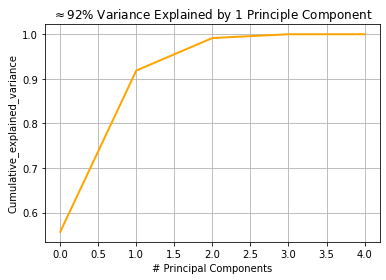

In [ ]:
percentage_var_explained = pca.explained_variance_ /np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

# Draw the plot
plt.figure(1, figsize=(6, 4))

plt.plot(cum_var_explained, linewidth=2, color='orange')
plt.axis('tight')
plt.grid()
plt.xlabel('# Principal Components')
plt.ylabel('Cumulative_explained_variance')
#plt.title(r"$150$ Principle Components accounts for $\approx 100\%$ Variance", fontsize = 10)
plt.title(r"$\approx 92\%$ Variance Explained by 1 Principle Component", fontsize = 12)
plt.show()

In [ ]:
pca = PCA(n_components=1)
kpi_award_trainingScore_rating_edu = pca.fit(pca_data.loc[train_index,:])
kpi_award_trainingScore_rating_edu = pca.transform(pca_data)

In [ ]:
X['pca_combined'] = kpi_award_trainingScore_rating_edu

# Feature Selection

## Univariate Feature Selection

### Categorical Features

In [ ]:
# mutual_info_classif(X.loc[train_index, categorical_features],
#                     X.loc[train_index,'is_promoted'],
#                     discrete_features=True)

# If train_index loaded from disk
importance = mutual_info_classif(X = data.loc[train_index.values.flatten(), categorical_features],
                                 y = y[train_index.values.flatten()],
                                 discrete_features=True)

In [ ]:
print('Categorical Features in descendig order of importance')
print('-'*50, end='\n\n')

temp_data = pd.DataFrame(data=np.column_stack((categorical_features,importance)), columns= ['feature', 'mutual_info'])
temp_data.mutual_info = temp_data.mutual_info.astype('float').round(5)
temp_data.sort_values('mutual_info', ascending=False)

Categorical Features in descendig order of importance
--------------------------------------------------



,feature,mutual_info
6,KPIs_met >80%,0.02249
5,previous_year_rating,0.01381
7,awards_won?,0.01113
1,region,0.00446
0,department,0.00149
2,education,0.00065
4,recruitment_channel,0.00017
3,gender,0.00004
8,previous_rating_na,0.00000


### Numerical Features 

In [ ]:
numerical_data = X.loc[:, numerical_features]
numerical_data['joining_age'] = joining_age
numerical_data['total_score'] = total_score
numerical_data['pca_combined'] = kpi_award_trainingScore_rating_edu

In [ ]:
num_importance = mutual_info_classif(X = numerical_data.loc[train_index, :], y = X.loc[train_index,'is_promoted'],
                                     discrete_features=False)
# num_importance = mutual_info_classif(X = data.loc[train_index.values.flatten(), numerical_features],
#                                      y = y[train_index.values.flatten()],
#                                      discrete_features=False)

In [ ]:
# 2nd run

print('Numerical Features in descendig order of importance (Mutual Information test):')
print('-'*50, end='\n\n')

temp_data = pd.DataFrame(data=np.column_stack((numerical_data.columns,num_importance)), columns= ['feature', 'mutual_info'])
temp_data.mutual_info = temp_data.mutual_info.astype('float').round(5)
temp_data.sort_values('mutual_info', ascending=False)

Numerical Features in descendig order of importance (Mutual Information test):
--------------------------------------------------



,feature,mutual_info
6,pca_combined,0.06898
5,total_score,0.02985
3,avg_training_score,0.02807
0,no_of_trainings,0.00331
1,age,0.00009
2,length_of_service,0.00000
4,joining_age,0.00000


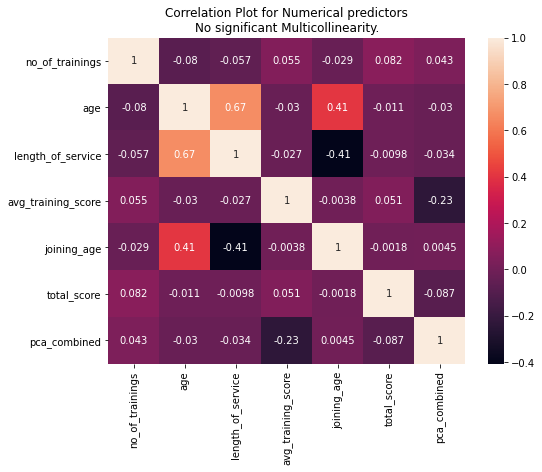

In [ ]:
# col = list(numerical_data.columns)
# col.append('is_promoted')

plt.figure(figsize=(8,6))
sns.heatmap(numerical_data.corr(), annot=True)
plt.title('Correlation Plot for Numerical predictors\nNo significant Multicollinearity.')
plt.show()

In [ ]:
del numerical_data

In [ ]:
univariate_features_selected = ['department', 'region', 'awards_won?', 
                                'previous_year_rating', 'KPIs_met >80%',
                                'avg_training_score', 'total_score', 'pca_combined']

<h3> Univariately Selected Features: </h3>

- `department`
- `region`
- `awards_won?` 
- `previous_year_rating`
- `KPIs_met >80%`
- `avg_training_score`
- `total_score`
- `pca_combined`

### Base Model with Univariate selected data

In [ ]:
temp_data = X.loc[:, univariate_features_selected]

y = X.is_promoted

In [ ]:
#### Responsecoding ####

categorical_features = ['department', 'region', 'education', 'gender',
                        'recruitment_channel','previous_year_rating',
                        'KPIs_met >80%', 'awards_won?', 'previous_rating_na']

for feature in categorical_features:
    
    if (feature in univariate_features_selected) and  (feature != 'previous_year_rating'): # 'previous_year_rating' is already in float
        encoder = ResponseCoding().fit(temp_data.loc[train_index,feature],
                                       y[train_index] 
                                      )
        
        temp_data[feature] = encoder.transform(temp_data[feature])[1] # [1] only value for label 1


In [ ]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(temp_data.loc[train_index, :], y[train_index]);

y_pred = tree_clf.predict(temp_data.loc[validate_index,:])

print('F1 score:', f1_score(y[validate_index], y_pred))
print('Accuracy:', accuracy_score(y[validate_index], y_pred))

F1 score: 0.46601941747572817
Accuracy: 0.9247400109469075


In [ ]:
del temp_data